# NER 데이터 전처리

한국어 NER 데이터를 버트로 학습하려면 데이터 구조를 변경해야 한다.

### 학습 환경 구성

In [ ]:
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/requirements.txt -O requirements.txt
!pip install -r requirements.txt
!pip install tensorflow==2.2.0

--2021-08-04 13:10:52--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 610 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     610  --.-KB/s    in 0s      

2021-08-04 13:10:52 (32.0 MB/s) - ‘requirements.txt’ saved [610/610]

     |████████████████████████████████| 17.3 MB 28 kB/s 
     |████████████████████████████████| 1.4 MB 46.2 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 769 kB 56.8 MB/s 
     |████████████████████████████████| 1.0 MB 49.1 MB/s 
     |████████████████████████████████| 46.9 MB 35 kB/s 
     |████████████████████████████████| 252 kB 74.4 MB/s 
     |█

In [ ]:
!mkdir -p data_in/KOR/NER
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/NER/label.txt \
        -O data_in/KOR/NER/label.txt
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/NER/test.tsv \
        -O data_in/KOR/NER/test.tsv
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/NER/train.tsv \
        -O data_in/KOR/NER/train.tsv

--2021-08-04 13:12:53--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/NER/label.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173 [text/plain]
Saving to: ‘data_in/KOR/NER/label.txt’

data_in/KOR/NER/lab 100%[===================>]     173  --.-KB/s    in 0s      

2021-08-04 13:12:53 (10.6 MB/s) - ‘data_in/KOR/NER/label.txt’ saved [173/173]

--2021-08-04 13:12:53--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/NER/test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
H

In [ ]:
import os
import re
import numpy as np
from tqdm import tqdm
import json
import copy

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string])
    plt.show()

### NER 데이터와 학습에 필요한 기본 값 선언

최대한 일관된 결괏값을 도출하기 위해 tf.random.set_seed와 np.random.seed 고정하고 최대 길이값, 데이터 경로 등을 선언한다.

In [ ]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
MAX_LEN = 111 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [ ]:
# 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.tsv")
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv")

def read_file(input_path):
    """Read tsv file, and return words and label as list"""
    with open(input_path, "r", encoding="utf-8") as f:
        sentences = []
        labels = []
        for line in f:
            split_line = line.strip().split("\t")
            sentences.append(split_line[0])
            labels.append(split_line[1])
        return sentences, labels

train_sentences, train_labels = read_file(DATA_TRAIN_PATH)

train_ner_dict = {"sentence": train_sentences, "label": train_labels}
train_ner_df = pd.DataFrame(train_ner_dict)

test_sentences, test_labels = read_file(DATA_TEST_PATH)
test_ner_dict = {"sentence": test_sentences, "label": test_labels}
test_ner_df = pd.DataFrame(test_ner_dict)

print("개체명 인식 학습 데이터 개수: {}".format(len(train_ner_df)))
print("개체명 인식 테스트 데이터 개수: {}".format(len(test_ner_df)))

개체명 인식 학습 데이터 개수: 81000
개체명 인식 테스트 데이터 개수: 9000


In [ ]:
# Label 불러오기

def get_labels(label_path):
    return [label.strip() for label in open(os.path.join(label_path), 'r', encoding='utf-8')]

ner_labels = get_labels(DATA_LABEL_PATH)

print("개체명 인식 레이블 개수: {}".format(len(ner_labels)))

개체명 인식 레이블 개수: 30


- pad_token_id : 라벨이 시퀀스 길이에 맞춰져 있기 때문에 주어진 입력의 길이 기반으로 패딩하기 위해 필요한 값
- pad_token_label_id : 학습 시 라벨된 값 외에 학습에 영향을 미치지 않기 위해 설정되는 값
- cls_token_label_id : 손실 값을 구성할 때 시퀀스가 모두 영향을 미치는 개체명 분야의 특성으로 인해 인식에 필요한 값 외에는 모두 0으로 지정하여 학습에 영향을 미치지 않도록 한다.

In [ ]:
# 버트 토크나이저 설정

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt')

pad_token_id = tokenizer.pad_token_id # 0
pad_token_label_id = 0
cls_token_label_id = 0
sep_token_label_id = 0

### bert_tokenizer 함수 실행

버트 토크나이저를 불러오고 encode_plus 기능을 통해 input_id, attention_mask, token_type_id를 생성한다.

### convert_label 함수 실행

띄어쓰기 단위로 구성된 라벨을 버트 토크나이저에 맞는 형태로 변형한다.

버트 토크나이저로 분해된 개체명의 첫 버트 토큰 부분을 B 라벨로 지정하고 나머지는 I 라벨로 지정한다.

In [ ]:
def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        truncation=True,
        add_special_tokens = True, #'[CLS]'와 '[SEP]' 추가
        max_length = MAX_LEN,           # 문장 패딩 및 자르기 진행
        pad_to_max_length = True,
        return_attention_mask = True   # 어탠션 마스크 생성
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] 
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id

def convert_label(words, labels_idx, ner_begin_label, max_seq_len):
            
    tokens = []
    label_ids = []

    for word, slot_label in zip(words, labels_idx):

        word_tokens = tokenizer.tokenize(word)
        if not word_tokens:
            word_tokens = [unk_token]
        tokens.extend(word_tokens)
        
        # 슬롯 레이블 값이 Begin이면 B로 추가
        if int(slot_label) in ner_begin_label:
            label_ids.extend([int(slot_label)] + [int(slot_label) + 1] * (len(word_tokens) - 1))
        # 나머지는 I로 추가
        else:
            label_ids.extend([int(slot_label)] * len(word_tokens))
  
    # [CLS] and [SEP] 설정
    special_tokens_count = 2
    if len(label_ids) > max_seq_len - special_tokens_count:
        label_ids = label_ids[: (max_seq_len - special_tokens_count)]

    # [SEP] 토큰 추가
    label_ids += [sep_token_label_id]

    # [CLS] 토큰 추가
    label_ids = [cls_token_label_id] + label_ids
    
    padding_length = max_seq_len - len(label_ids)
    label_ids = label_ids + ([pad_token_label_id] * padding_length)
    
    return label_ids

띄어쓰기로 나눠진 단어와 라벨 값을 받은 후, 단어를 버트 토크나이저로 분해하여 분해된 길이에 맞게 라벨을 조정한다.

ner_begin_label 값은 PER-B처럼 B로 시작되는 라벨 값의 집합이다.

먼저, for문에서 word_tokens에 토크나이징된 결과가 할당되어 단어가 분절되며 분절된 부분에 대하여 if문을 통해 새로운 개체명 라벨을 붙여준다.

버트 토크나이저 이후에는 전체 라벨 길이를 맞춰준다.

### ner_begin_label에 대한 인덱스 및 해당 텍스트 값

In [ ]:
# 테스트용
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]
ner_begin_label_string = [ner_labels[label_index] for label_index in ner_begin_label]

print(ner_begin_label)
print(ner_begin_label_string)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
['PER-B', 'FLD-B', 'AFW-B', 'ORG-B', 'LOC-B', 'CVL-B', 'DAT-B', 'TIM-B', 'NUM-B', 'EVT-B', 'ANM-B', 'PLT-B', 'MAT-B', 'TRM-B']


### create_inputs_targets 함수 실행

학습 데이터를 제작하는 함수다.

In [ ]:
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]

def create_inputs_targets(df):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    label_list = []

    # 각 데이터 프레임에 있는 문장과 라벨을 띄어쓰기 단위로 만들어 각각 words와 labels 변수에 저장한다.

    for i, data in enumerate(df[['sentence', 'label']].values):
        sentence, labels = data
        words = sentence.split()
        labels = labels.split()
        labels_idx = []
        
        # labels_idx에 labels의 값들을 인덱스로 변환한다.

        for label in labels:
            labels_idx.append(ner_labels.index(label) if label in ner_labels else ner_labels.index("UNK"))

        assert len(words) == len(labels_idx)

        # encode_plus를 사용헤 bert_tokenizer에서 버트에 필요한 input_id, attention_mask, token_type_id를 생성한다.

        input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)

        # 띄어쓰기 단위의 라벨을 토큰 단위로 변환하는 convert_label 함수를 호출해서 라벨 토큰 단위로 변환한다.

        convert_label_id = convert_label(words, labels_idx, ner_begin_label, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        label_list.append(convert_label_id)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    label_list = np.asarray(label_list, dtype=int) #레이블 토크나이징 리스트
    inputs = (input_ids, attention_masks, token_type_ids)
    
    return inputs, label_list

# 학습셋과 테스트셋 생성 완료

train_inputs, train_labels = create_inputs_targets(train_ner_df)
test_inputs, test_labels = create_inputs_targets(test_ner_df)

# NER 모델 학습 및 테스트

TFBertNERClassifier 모델을 구현한다.



In [ ]:
class TFBertNERClassifier(tf.keras.Model):


    # __init__ 메소드에 모델 이름, 저장된 위치, 클래스 개수를 받아온다.

    def __init__(self, model_name, dir_path, num_class):
        super(TFBertNERClassifier, self).__init__()

        # 사전 학습된 가중치를 불러와 classifier로 정의된 선형층을 사용해 원하는 출력값의 클래스를 정의한다.

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                                name="ner_classifier")

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):

        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        
        #벡터의 차원은 '임베딩 크기*최대 문장 길이(768*111)
        sequence_output = outputs[0] 
                
        sequence_output = self.dropout(sequence_output, training=training)
        logits = self.classifier(sequence_output)
        

        return logits

In [ ]:
ner_model = TFBertNERClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=len(ner_labels))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


### 개체명 인식의 출력 과정

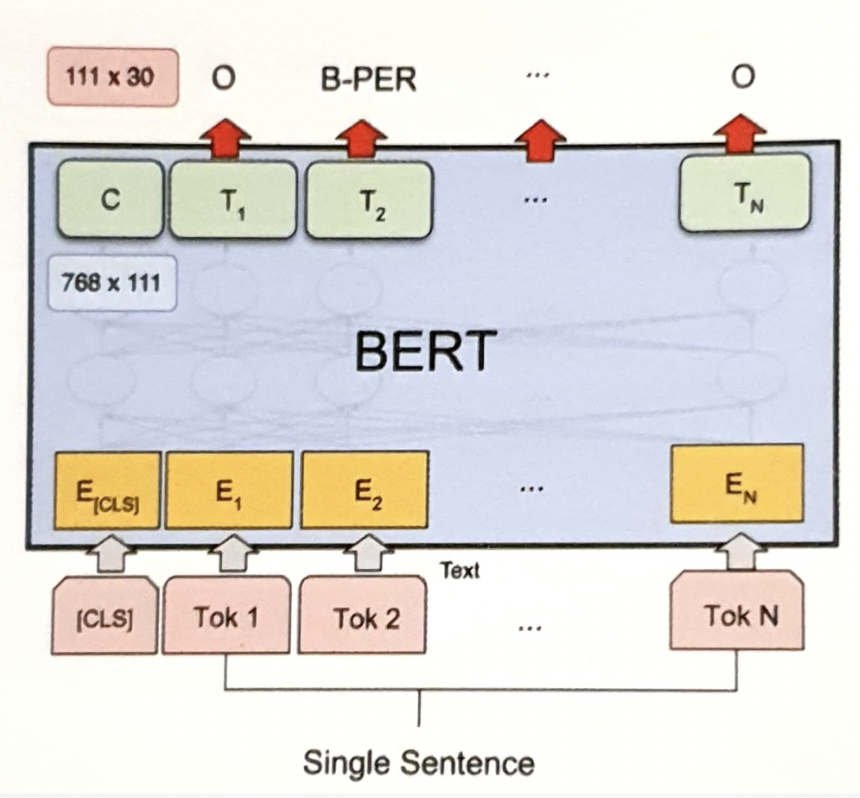

### compute_loss 함수 실행

In [ ]:
def compute_loss(labels, logits):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    )

    # 0의 레이블 값은 손실 값을 계산할 때 제외
    # 마스킹 처리를 위해 reshape을 통해 배치 labels의 값을 1차원값으로 치환
    # 치환된 값에 0이 아닌 모든 값들은 True, 0이면 False
    active_loss = tf.reshape(labels, (-1,)) != 0
        
    reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, shape_list(logits)[2])), active_loss)
        
    labels = tf.boolean_mask(tf.reshape(labels, (-1,)), active_loss)
    
    return loss_fn(labels, reduced_logits)

### active_loss 입력 값의 변화 과정

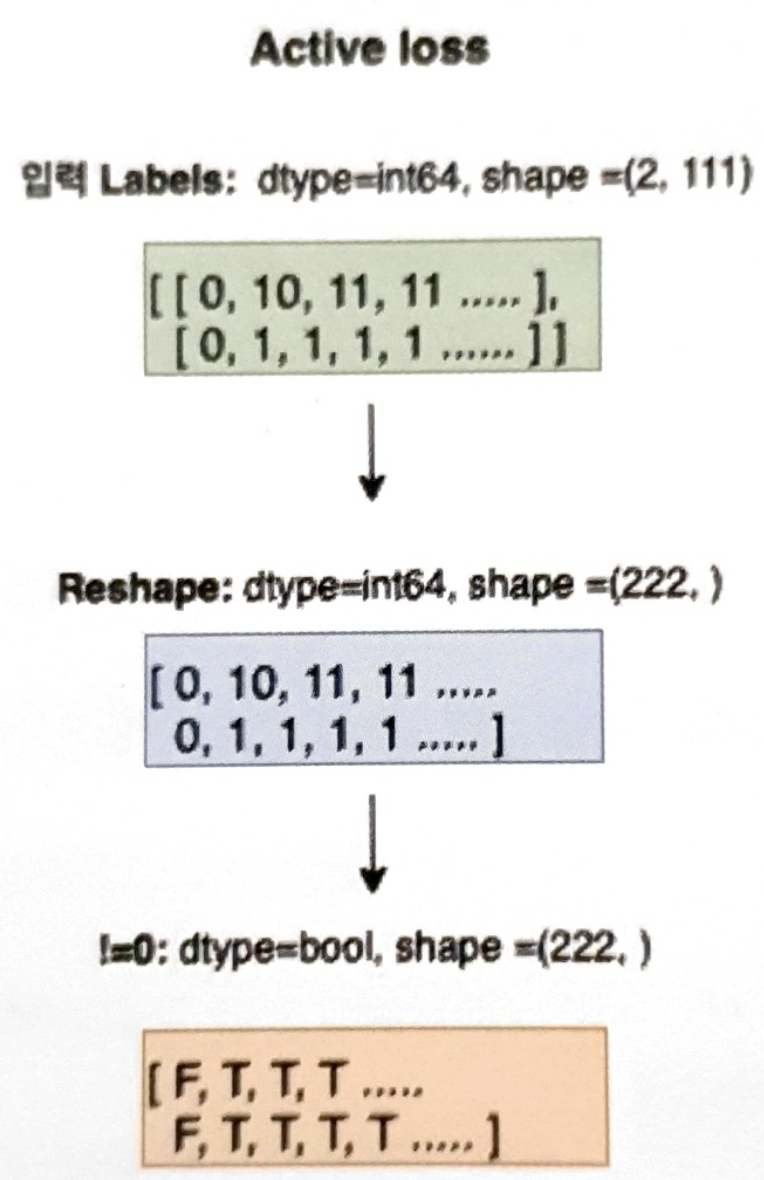

### 혼동 행렬

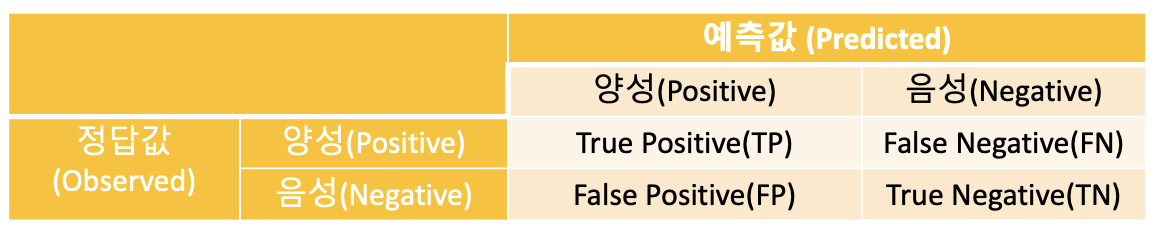

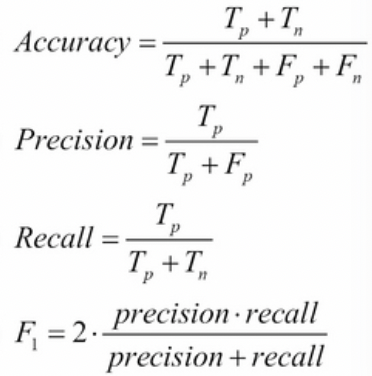

### F1 Score 구현

F1 Score는 정밀도와 재현율을 조화평균한 값이다.

In [ ]:
class F1Metrics(tf.keras.callbacks.Callback):
    
    # 테스트 데이터 입력값인 x_eval과 라벨값인 y_eval을 받는다
    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def compute_f1_pre_rec(self, labels, preds):

        return {
            "precision": precision_score(labels, preds, suffix=True),
            "recall": recall_score(labels, preds, suffix=True),
            "f1": f1_score(labels, preds, suffix=True)
        }

    # 요약 리포트 출력
    def show_report(self, labels, preds):
        return classification_report(labels, preds, suffix=True)
        
    def on_epoch_end(self, epoch, logs=None):

        # 테스트 데이터의 결괏값 저장하기 위해 results로 딕셔너리 초기화
        results = {}

        # 현재 문장의 입력을 모델에 통과시켜 pred 출력하고 argmax로 가장 높은 라벨 예측값을 출력 
        pred = self.model.predict(self.x_eval)
        label = self.y_eval
        pred_argmax = np.argmax(pred, axis = 2)

        # F1 score 계산에 필요한 값을 구하기 위해 현재 인덱스로 치환되어 있는 예측값과 정답값을 다시 텍스트 형태로 변환
        # 기존에 개체명 라벨을 저장한 ner_labels를 활용해 각 개체명 라벨을 딕셔너리 형태로 slot_label_map에 생성
        slot_label_map = {i: label for i, label in enumerate(ner_labels)}

        # F1 score 평가를 위해 빈 리스트를 평가 데이터 개수만큼 생성
        # 테스트 데이터는 현재 매트릭스 형태이므로 해당 크기에 맞춰 미리 out_label_list랑 preds_list 리스트 생성
        out_label_list = [[] for _ in range(label.shape[0])]
        preds_list = [[] for _ in range(label.shape[0])]

        # 예측한 인덱스 값인 pred_argmax를 개체명으로 치환해서 preds_list에 저장
        # label.shape[0]은 평가 데이터 정답 인스턴스의 수
        for i in range(label.shape[0]):

            # label.shape[1]은 각 라벨의 길이를 의미하는데, 여기에서는 지정한 값 111
            for j in range(label.shape[1]):

                # 0값 제외
                if label[i, j] != 0:

                    # 라벨 인덱스를 텍스트 인덱스로 변환
                    # 정답 라벨 인덱스 값으로, slot_label_map으로 label에 있는 인덱스값을 텍스트로 변
                    out_label_list[i].append(slot_label_map[label[i][j]])
                    preds_list[i].append(slot_label_map[pred_argmax[i][j]])

        # compute_f1_pre_rec 함수로 텍스트 레이블로 치환된 예측값과 정답 레이블 값을 계산
        # results에 점수 업데이트 후 f1 score, 정밀도 및 재현율을 계산        
        result = self.compute_f1_pre_rec(out_label_list, preds_list)
        results.update(result)

        print("********")
        print("F1 Score")
        for key in sorted(results.keys()):
            print("{}, {:.4f}".format(key, results[key])

        # show_report로 classification_report 기능을 사용해 각 개체명 별 최종 결괏값 출력    
        print("\n" + self.show_report(out_label_list, preds_list))
        print("********")

f1_score_callback = F1Metrics(test_inputs, test_labels)

In [ ]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
# 버트에서 미세 조정을 진행할 때 사용하는 learning_rate 3e-5를 사용
optimizer = tf.keras.optimizers.Adam(3e-5용
                                     
# ner_model.compile(optimizer=optimizer, loss=compute_loss, run_eagerly=True)
ner_model.compile(optimizer=optimizer, loss=compute_loss)

In [ ]:
model_name = "tf2_bert_ner"

# 체크포인트가 저장될 부분을 저장
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

# 학습을 시작하기 위해 fit을 통해 모델의 학습 데이터 추가
# callbacks에 f1_score_callback을 추가해서 테스트 데이터의 f1 score 값 출력
history = ner_model.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                        callbacks=[cp_callback, f1_score_callback])

print(history.history)

data_out/KOR/tf2_bert_ner -- Folder create complete 

Epoch 1/3
2532/2532 [==============================] - ETA: 0s - loss: 0.4355WARNING:tensorflow:Can save best model only with val_loss available, skipping.
********
F1 Score
f1, 0.7451
precision, 0.7139
recall, 0.7791

              precision    recall  f1-score   support

         AFW       0.43      0.45      0.44       393
         ANM       0.51      0.73      0.60       699
         CVL       0.66      0.72      0.69      5735
         DAT       0.79      0.88      0.83      2510
         EVT       0.62      0.72      0.67      1093
         FLD       0.49      0.46      0.47       228
         LOC       0.65      0.78      0.71      2124
         MAT       0.00      0.00      0.00        12
         NUM       0.86      0.88      0.87      5544
         ORG       0.74      0.76      0.75      4055
         PER       0.74      0.83      0.79      4412
         PLT       0.00      0.00      0.00        34
         TIM       0.78 

### NER 분야의 loss 그래프

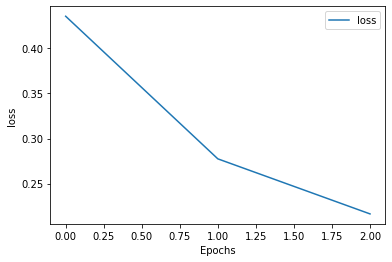

In [ ]:
plot_graphs(history, 'loss')